# Neural Network

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from hotel_preprocessing import clean_data, extract_features, drop_columns, XYPreprocessor

# Load dataset
df = pd.read_csv("hotel_bookings.csv")  # alr scaled, clean data
hotel = df.copy()


In [2]:
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# Stage 1 - Predict Cancel/ Not

## Split Data into Training, Test (Time-based holdout)

In [3]:
# Combine year, month, and day columns into a single datetime column
hotel['arrival_date'] = pd.to_datetime(
    hotel['arrival_date_year'].astype(str) + '-' +
    hotel['arrival_date_month'] + '-' +
    hotel['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d'  # Ensure proper month name parsing
)

# Determine the latest arrival date
last_date = hotel['arrival_date'].max()

# Define the cutoff date for the last 3 months
cutoff_date = last_date - pd.DateOffset(months=3)

# Split by cutoff date
test_data = hotel[hotel['arrival_date'] > cutoff_date].reset_index(drop=True)
train_val_data = hotel[hotel['arrival_date'] <= cutoff_date].reset_index(drop=True)

# Separate raw features and labels
X_train_val_raw = train_val_data.drop(columns=['is_canceled'])
y_train_val_raw = train_val_data['is_canceled'].astype(int)

X_test_raw = test_data.drop(columns=['is_canceled'])
y_test_raw = test_data['is_canceled'].astype(int)



## Preprocess + Clean data

In [ ]:
# Preprocess train_val once, then split into folds
preprocessor = XYPreprocessor()
X_train_val, y_train_val = preprocessor.fit_transform(X_train_val_raw, y_train_val_raw)

# Transform test set using the same preprocessor
X_test, y_test = preprocessor.transform(X_test_raw, y_test_raw)

# print the shapes of the datasets
print(f"X_train: {X_train_val.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train_val.shape}, y_test shape: {y_test.shape}")

X_train: (74216, 99), X_test shape: (13161, 99)
y_train shape: (74216,), y_test shape: (13161,)


## Model Training

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import optuna

# --- Neural Network Definition ---
class CancellationNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout=0.3):
        super(CancellationNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),   # Input layer with 128 neurons
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),  # ELU might be overkill since rather shallow network
            nn.Dropout(dropout),    # Randomly zeroes out 30% of activations during training to prevent overfitting

            nn.Linear(hidden_dim, hidden_dim // 2), # Compresses feature map to half size (from 128 → 64)
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout / 2),    # less dropout in the second layer to retain more information

            nn.Linear(hidden_dim // 2, 1),  # Output layer with 1 neuron for binary classification
            nn.Sigmoid()  # Needed for binary classification output
        )

    def forward(self, x):
        return self.model(x).squeeze()



In [9]:
# --- Training Function ---
def train_model(X, y, params, device):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)    # 5-fold cross-validation
    val_aucs = []

    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model = CancellationNet(X.shape[1], params['hidden_dim'], params['dropout']).to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

        train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=params['batch_size'], shuffle=True)

        best_auc = 0
        patience = 3
        counter = 0

        for epoch in range(params['epochs']):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_preds = model(X_val.to(device)).cpu().numpy()
                auc = roc_auc_score(y_val.numpy(), val_preds)
                scheduler.step(auc)

                if auc > best_auc:
                    best_auc = auc
                    counter = 0
                else:
                    counter += 1

            if counter >= patience:
                break

        val_aucs.append(best_auc)

    return np.mean(val_aucs)

In [10]:
X_train_tensor = torch.tensor(X_train_val.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_val.values, dtype=torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
# --- Optuna Objective Function ---
def objective(trial):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [64, 128, 256]),
        'dropout': trial.suggest_float('dropout', 0.2, 0.5),
        'lr': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        'epochs': trial.suggest_int('epochs', 5, 15)
    }
    return train_model(X_train_tensor, y_train_tensor, params, device)

# --- Run Hyperparameter Tuning ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_params = study.best_trial.params
print("\n✅ Best Validation AUC: {:.4f}".format(study.best_value))
print("Best Hyperparameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

[I 2025-06-21 15:59:59,335] A new study created in memory with name: no-name-a96d2567-e794-47a4-a8bf-78d114dad462
[I 2025-06-21 16:00:34,608] Trial 0 finished with value: 0.9176832946612986 and parameters: {'hidden_dim': 64, 'dropout': 0.21605339869940726, 'lr': 0.009337652453980981, 'batch_size': 64, 'epochs': 13}. Best is trial 0 with value: 0.9176832946612986.
[I 2025-06-21 16:00:52,513] Trial 1 finished with value: 0.8839118188802855 and parameters: {'hidden_dim': 64, 'dropout': 0.2486359578046889, 'lr': 4.1062850167214725e-05, 'batch_size': 64, 'epochs': 7}. Best is trial 0 with value: 0.9176832946612986.
[I 2025-06-21 16:01:49,846] Trial 2 finished with value: 0.9182357179967273 and parameters: {'hidden_dim': 256, 'dropout': 0.378371316412407, 'lr': 0.0002779230594213686, 'batch_size': 64, 'epochs': 15}. Best is trial 2 with value: 0.9182357179967273.
[I 2025-06-21 16:02:14,917] Trial 3 finished with value: 0.9161531382028005 and parameters: {'hidden_dim': 128, 'dropout': 0.31177


✅ Best Validation AUC: 0.9191
Best Hyperparameters:
  hidden_dim: 256
  dropout: 0.41692780725213924
  lr: 0.002051663351677729
  batch_size: 64
  epochs: 12


In [12]:
import torch.nn.functional as F

# --- Final Training on Full Training Set ---
final_model = CancellationNet(X_train_tensor.shape[1], best_params['hidden_dim'], best_params['dropout']).to(device)
optimizer = torch.optim.AdamW(final_model.parameters(), lr=best_params['lr'], weight_decay=1e-4)
criterion = nn.BCELoss()

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=best_params['batch_size'], shuffle=True)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

final_model.train()
for epoch in range(best_params['epochs']):
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = final_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        
# save best model
torch.save({
    'model_state_dict': final_model.state_dict(),
    'model_hyperparams': best_params
}, "best_nn_model_full.pth")

In [14]:
def get_top_feature_importances(model, feature_names, top_n=5):
    """
    Extracts and ranks feature importances from the first layer of a neural network.

    Args:
        model (nn.Module): Trained CancellationNet model.
        feature_names (list): List of feature names in order.
        top_n (int): Number of top features to return.

    Returns:
        DataFrame with top features and their normalized importance scores.
    """
    model.eval()
    with torch.no_grad():
        # Extract weights from the first Linear layer
        first_layer = model.model[0]  # Assuming model.model[0] is nn.Linear
        weights = first_layer.weight.data.cpu().numpy()  # shape: [hidden_dim, input_dim]
        
        # Aggregate importance: sum of absolute weights across neurons
        importance_scores = np.abs(weights).sum(axis=0)  # shape: [input_dim]
        importance_scores /= importance_scores.sum()     # normalize to sum to 1

        # Create DataFrame for easy sorting
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance_scores
        })

        top_features_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)
        return top_features_df

top_features_df = get_top_feature_importances(final_model, X_train_val.columns.tolist(), top_n=5)

print("\n🔍 Top 5 Most Important Features (Normalized):")
print(top_features_df.to_string(index=False))


🔍 Top 5 Most Important Features (Normalized):
                       Feature  Importance
        previous_cancellations    0.092935
   required_car_parking_spaces    0.091382
previous_bookings_not_canceled    0.028397
                           adr    0.025995
     total_of_special_requests    0.023780


## Test Model

In [15]:
# --- Evaluate on Test Set ---
final_model.eval()
with torch.no_grad():
    test_preds = final_model(X_test_tensor.to(device)).cpu().numpy()
    test_binary = (test_preds >= 0.5).astype(int)
    y_true = y_test_tensor.cpu().numpy()

# --- Evaluation Metrics ---
test_auc = roc_auc_score(y_true, test_preds)
acc = accuracy_score(y_true, test_binary)
prec = precision_score(y_true, test_binary)
rec = recall_score(y_true, test_binary)
f1 = f1_score(y_true, test_binary)

print("\n📊 Final Test Set Evaluation:")
print(f"AUC:       {test_auc:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")


📊 Final Test Set Evaluation:
AUC:       0.8670
Accuracy:  0.7853
Precision: 0.7062
Recall:    0.6715
F1 Score:  0.6884


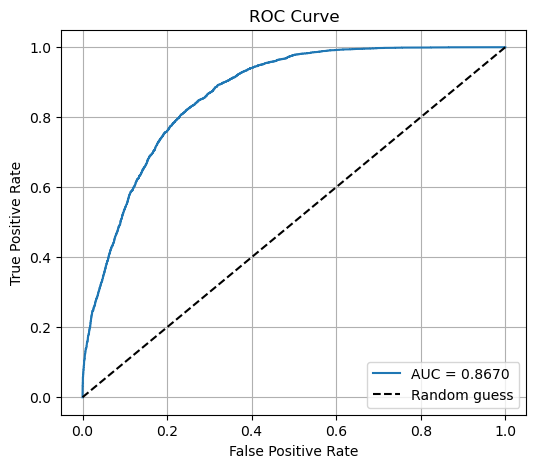

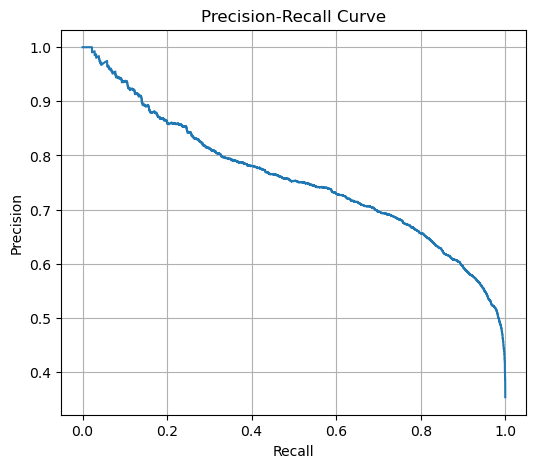

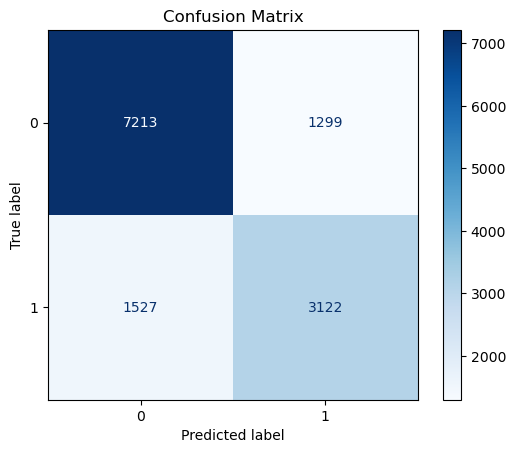

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

# --- Plot ROC Curve ---
fpr, tpr, _ = roc_curve(y_true, test_preds)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- Plot Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_true, test_preds)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# --- Plot Confusion Matrix ---
cm = confusion_matrix(y_true, test_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Stage 2 - Predict Cancel / No-show among those who did cancel

In [17]:
# === Load data and preprocess arrival date ===
hotel_data = df.copy()

hotel_data['arrival_date'] = pd.to_datetime(
    hotel_data['arrival_date_year'].astype(str) + '-' +
    hotel_data['arrival_date_month'] + '-' +
    hotel_data['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d'
)
hotel_data['reservation_status_date'] = pd.to_datetime(hotel_data['reservation_status_date'])

# Define target: 1 if No-Show OR cancelled within 3 days before arrival, else 0
hotel_data['days_before_arrival'] = (hotel_data['arrival_date'] - hotel_data['reservation_status_date']).dt.days
hotel_data['late_or_noshow'] = ((hotel_data['reservation_status'] == 'No-Show') |
                                 ((hotel_data['reservation_status'] == 'Canceled') & (hotel_data['days_before_arrival'] <= 3))).astype(int)

# === Filter to only canceled reservations for stage 2 analysis ===
hotel_data = hotel_data[hotel_data['is_canceled'] == 1].reset_index(drop=True)

# === Split train/test by arrival_date ===
last_date = hotel_data['arrival_date'].max()
cutoff_date = last_date - pd.DateOffset(months=3)

test_data = hotel_data[hotel_data['arrival_date'] > cutoff_date].reset_index(drop=True)
train_val_data = hotel_data[hotel_data['arrival_date'] <= cutoff_date].reset_index(drop=True)

cols_to_drop = [
    'reservation_status', 'reservation_status_date', 'arrival_date',
    'days_before_arrival', 'is_canceled'
]

X_train_val_raw = train_val_data.drop(columns=cols_to_drop + ['late_or_noshow'])
y_train_val_raw = train_val_data['late_or_noshow']

X_test_raw = test_data.drop(columns=cols_to_drop + ['late_or_noshow'])
y_test_raw = test_data['late_or_noshow']

# === Preprocess ===
preprocessor = XYPreprocessor()
X_train_val, y_train_val = preprocessor.fit_transform(X_train_val_raw, y_train_val_raw)
X_test, y_test = preprocessor.transform(X_test_raw, y_test_raw)

In [18]:
# print the shapes of the datasets
print(f"X_train: {X_train_val.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train_val.shape}, y_test shape: {y_test.shape}")

X_train: (19142, 99), X_test shape: (4624, 99)
y_train shape: (19142,), y_test shape: (4624,)


## Model Training

In [19]:
X_train_tensor = torch.tensor(X_train_val.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_val.values, dtype=torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Optuna Objective Function ---
def objective(trial):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [64, 128, 256]),
        'dropout': trial.suggest_float('dropout', 0.2, 0.5),
        'lr': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        'epochs': trial.suggest_int('epochs', 5, 15)
    }
    return train_model(X_train_tensor, y_train_tensor, params, device)

# --- Run Hyperparameter Tuning ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_params = study.best_trial.params
print("\n✅ Best Validation AUC: {:.4f}".format(study.best_value))
print("Best Hyperparameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

[I 2025-06-21 16:53:42,811] A new study created in memory with name: no-name-a10915de-54fa-4b92-8ace-5a6c1616ea2e
[I 2025-06-21 16:53:46,900] Trial 0 finished with value: 0.876017712913548 and parameters: {'hidden_dim': 256, 'dropout': 0.2377188533479771, 'lr': 0.0022103482039384967, 'batch_size': 128, 'epochs': 10}. Best is trial 0 with value: 0.876017712913548.
[I 2025-06-21 16:53:58,673] Trial 1 finished with value: 0.876003844072285 and parameters: {'hidden_dim': 256, 'dropout': 0.2381015505140488, 'lr': 0.00993348820075049, 'batch_size': 32, 'epochs': 9}. Best is trial 0 with value: 0.876017712913548.
[I 2025-06-21 16:54:02,822] Trial 2 finished with value: 0.8663039183340995 and parameters: {'hidden_dim': 256, 'dropout': 0.29735410904907, 'lr': 0.00012535677582911061, 'batch_size': 64, 'epochs': 5}. Best is trial 0 with value: 0.876017712913548.
[I 2025-06-21 16:54:13,287] Trial 3 finished with value: 0.8788299909476889 and parameters: {'hidden_dim': 64, 'dropout': 0.366880305614


✅ Best Validation AUC: 0.8811
Best Hyperparameters:
  hidden_dim: 64
  dropout: 0.30553600229434597
  lr: 0.0019051668704491915
  batch_size: 128
  epochs: 12


In [20]:
# --- Final Training on Full Training Set ---
final_model = CancellationNet(X_train_tensor.shape[1], best_params['hidden_dim'], best_params['dropout']).to(device)
optimizer = torch.optim.AdamW(final_model.parameters(), lr=best_params['lr'], weight_decay=1e-4)
criterion = nn.BCELoss()

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=best_params['batch_size'], shuffle=True)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

final_model.train()
for epoch in range(best_params['epochs']):
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = final_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        
# save best model
torch.save({
    'model_state_dict': final_model.state_dict(),
    'model_hyperparams': best_params
}, "best_nn_model_stage2_full.pth")

In [21]:
top_features_df = get_top_feature_importances(final_model, X_train_val.columns.tolist(), top_n=5)

print("\n🔍 Top 5 Most Important Features (Normalized):")
print(top_features_df.to_string(index=False))


🔍 Top 5 Most Important Features (Normalized):
               Feature  Importance
previous_cancellations    0.045827
         lead_time_log    0.038676
                adults    0.024582
          total_guests    0.020703
                   adr    0.020465


## Test Model

In [24]:
# --- Evaluate on Test Set ---
final_model.eval()
with torch.no_grad():
    test_preds = final_model(X_test_tensor.to(device)).cpu().numpy()
    test_binary = (test_preds >= 0.5).astype(int)
    y_true = y_test_tensor.cpu().numpy()

# --- Evaluation Metrics ---
test_auc = roc_auc_score(y_true, test_preds)
acc = accuracy_score(y_true, test_binary)
prec = precision_score(y_true, test_binary)
rec = recall_score(y_true, test_binary)
f1 = f1_score(y_true, test_binary)

print("\n📊 Final Test Set Evaluation:")
print(f"AUC:       {test_auc:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")


📊 Final Test Set Evaluation:
AUC:       0.8886
Accuracy:  0.9622
Precision: 0.8839
Recall:    0.4660
F1 Score:  0.6102


In [26]:
# print percentage of no-shows in the test set
no_show_percentage = np.mean(y_true) * 100
print(f"\n📊 Percentage of No-Shows in Test Set: {no_show_percentage:.2f}%")


📊 Percentage of No-Shows in Test Set: 6.36%


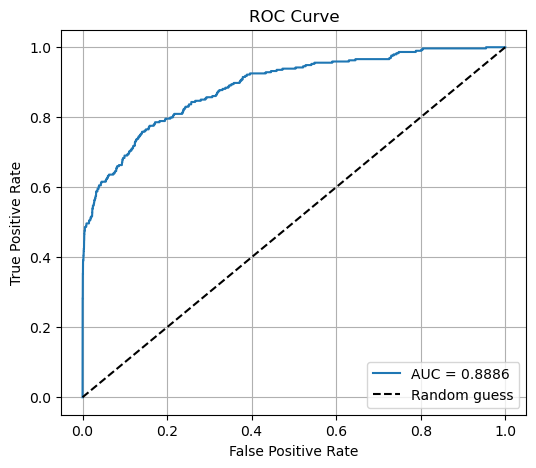

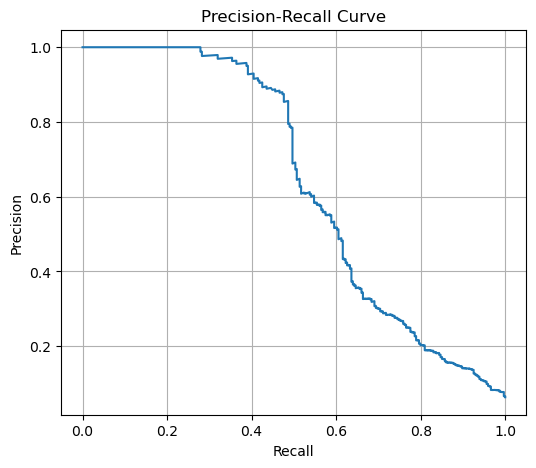

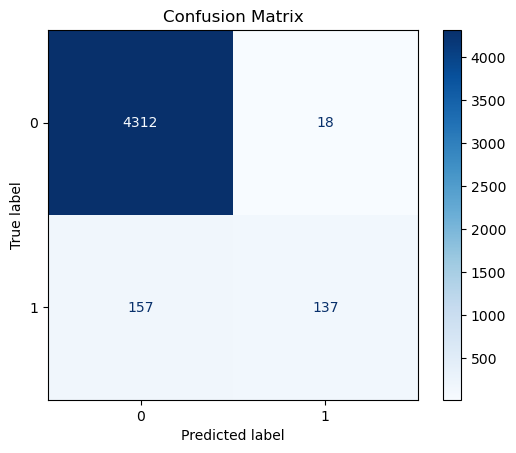

In [27]:
# --- Plot ROC Curve ---
fpr, tpr, _ = roc_curve(y_true, test_preds)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- Plot Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_true, test_preds)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# --- Plot Confusion Matrix ---
cm = confusion_matrix(y_true, test_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()